metadata_explore_refine.ipynb

## Refining EMP metadata: qiime mapping files fixed using pandas

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import math
from collections import defaultdict

In [2]:
pd.set_option("display.max_rows", 200)

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
# path to list of studies (ct112=all) and path to mapping files directory
path_studies = '/Users/luke/emp/metadata-refine/refine_emp_studies_ct112.txt'
path_mapping = '/Users/luke/emp/metadata-qiime-mapping'
path_empo = '/Users/luke/emp/metadata-refine/emp_qiime_mapping_sampletype_unique_empo.xlsx'

### Functions

#### Function for merging mapping files and tallying column headers

In [5]:
def merge_and_tally_mapping_files(path_studies, path_mapping):
    studies = [line.rstrip('\n') for line in open(path_studies)]
    header_counts = defaultdict(int)
    df_merged = pd.DataFrame()
    for study in studies:
        path = '%s/%s_qiime_mapping.tsv' % (path_mapping, study)
        df_single = pd.read_csv(path, sep='\t', header=0, index_col=0, dtype=str)
        for header in df_single.columns:
            header_counts[header] += 1
        df_merged = df_merged.append(df_single, ignore_index=False, verify_integrity=True)
    return df_merged, header_counts

#### Data munging functions

#### Remove trailing ".0" from numeric value in column of df (convert string-float to string-int)

In [6]:
def remove_decimal_zero(df, column):
    return [re.sub(r'\.0', '', x) if x is not np.nan else '' for x in df[column]]

#### Round to hundredths with df.apply(round_hundredths)

In [7]:
def round_hundredths(x):
    x = float(x)
    if math.isnan(x):
        return x
    else:
        return "%.2f" % x

### Read taxonomy data

In [8]:
df_tax = pd.read_csv('/Users/luke/emp/ontology-ncbi-taxonomy/taxdump/names.dmp', 
                     sep='\t\|\t|\t\|', engine='python', header=None)
del df_tax[4]
df_tax.columns = ['tax_id', 'name_txt', 'unique_name', 'name_class']
df_tax['tax_id'] = df_tax['tax_id'].astype(str)

In [9]:
# dictionary of tax_id => genbank common name
df_tax_gcn = df_tax[df_tax['name_class'] == 'genbank common name']
dict_gcn = dict(zip(df_tax_gcn.tax_id, df_tax_gcn.name_txt))

In [10]:
# dictionary of tax_id => scientific name
df_tax_sn = df_tax[df_tax['name_class'] == 'scientific name']
dict_sn = dict(zip(df_tax_sn.tax_id, df_tax_sn.name_txt))

### Read and refine mapping file

#### Read mapping files, tally column headers, and merge into single dataframe

In [11]:
# main code to merge mapping files and count how often column headers appear
df_merged, header_counts = merge_and_tally_mapping_files(path_studies, path_mapping)

In [12]:
# change spaces in indexes to periods (for study 905)
df_merged.index = [re.sub(' ', '.', x) for x in df_merged.index]

In [13]:
df_merged.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_union.tsv', sep='\t', index_label='#SampleID')

#### Metadata column headers most frequently used

In [14]:
header_counts_keys = header_counts.keys()
header_counts_values = header_counts.values()

In [15]:
# make list of column headers found in all studies
isect_cols = []
max_header_count = max(header_counts_values)
for header in header_counts:
    if header_counts[header] == max_header_count:
        isect_cols.append(header)
isect_cols.sort()

#### Generating condensed/merged mapping files

In [16]:
select_cols = [
    'Description',
    'country',
    'env_biome',
    'env_feature',
    'env_matter',
    'experiment_design_description',
    'host_subject_id',
    'latitude',
    'longitude',
    'samp_size',
    'sample_type',
    'taxon_id',
    'title']

In [17]:
df_isect = df_merged[isect_cols]
df_select = df_merged[select_cols]

#### Add EMPO columns to merged all columns and select columns (and covert indexes to lowercase to match biom)

In [132]:
df_empo = pd.read_excel(path_empo, index_col=0)

In [133]:
sampletype_cols = [
    'env_biome',
    'env_feature',
    'env_matter',
    'sample_type']

In [134]:
df_union_empo = pd.merge(df_merged, df_empo, how='left', left_on=sampletype_cols, right_on=sampletype_cols)
df_union_empo.index = [x for x in df_merged.index]
df_select_empo = pd.merge(df_select, df_empo, how='left', left_on=sampletype_cols, right_on=sampletype_cols)
df_select_empo.index = [x for x in df_select.index]

In [135]:
df_union_empo.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_union_empo.tsv', sep='\t', index_label='#SampleID')
df_select_empo.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_select_empo.tsv', sep='\t', index_label='#SampleID')

## Refined mapping file

_Sample_

* SampleID -- no changes needed
* BarcodeSequence -- no changes needed
* LinkerPrimerSequence -- no changes needed
* Description -- no changes needed
* host_subject_id -- no changes needed

_Study_

* study_id -- parsed from SampleID
* title -- fixed Excel Auto Fill and other typos

_Taxonomy_

* taxon_id -- removed trailing ".0", fixed Excel Auto Fill and other typos
* scientific_name -- deleted values that refer to host or don't match lookup value
* scientific_name_lookup -- looked up from names.dmp using taxon_id
* host_taxid -- removed trailing ".0", fixed Excel Auto Fill typos
* host_common_name -- no changes made, but see lookup value
* host_common_name_lookup -- looked up from names.dmp using host_taxid
* host_scientific_name_lookup -- looked up from names.dmp using host_taxid

_Geography_

* collection_timestamp -- removed timestamps after today's date
* country -- fixed misspellings
* latitude -- fixed errors
* longitude -- fixed errors
* depth -- no changes made
* altitude -- no changes made
* elevation -- no changes made

_Ontology_

* env_biome -- fixed errors -- need additional changes from gDoc
* env_feature -- no changes made -- need additional changes from gDoc
* env_material -- fixed errors, changed name from "env_matter" -- need additional changes from gDoc
* empo_0 -- no changes, inherited from Excel file
* empo_1 -- no changes, inherited from Excel file
* empo_2 -- no changes, inherited from Excel file
* empo_3 -- no changes, inherited from Excel file

_Environment_

* temperature -- using "temp", "temp_environment", made fully numeric
* ph -- using "ph" (fixed), "ph_cacl2", "sediment_ph", made fully numeric
* salinity -- using "salinity", "samp_salinity", "sediment_salinity", made fully numeric
* oxygen -- no changes made
* nitrogen spp.
* phosphorus spp.
* carbon spp.


### Create dataframe for refined columns

#### Sample metadata

In [136]:
df_refined = pd.DataFrame(index=df_merged.index)
df_refined.index.name = '#SampleID'

In [137]:
df_refined = df_refined.join(df_merged[['BarcodeSequence', 'LinkerPrimerSequence', 'Description', 'host_subject_id']])

#### Study metadata

In [138]:
df_refined['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]
df_refined['title'] = df_merged['title']

In [139]:
# title -- fix Excel Auto Fill typos in 662, 1521, consistent names in 1526, 1714, 1721
df_refined['title'][df_refined['study_id'] == '662'] = 'Intertidal microbes 16s for 2009 and 2010'
df_refined['title'][df_refined['study_id'] == '1521'] = 'Samples presented at EMP conference June 2011 Shenzhen'
df_refined['title'][df_refined['study_id'] == '1526'] = 'Recovery of biological soil crust-like microbial communities in previously submerged soils of Glen Canyon'
df_refined['title'][df_refined['study_id'] == '1714'] = 'Malaysia Pasoh Landuse Logged Forest'
df_refined['title'][df_refined['study_id'] == '1721'] = 'Thomas soil agricultural enhancement'

#### Taxonomy metadata

##### Sample taxonomy

In [140]:
df_refined = df_refined.join(df_merged[['taxon_id', 'scientific_name']])

In [141]:
# taxon_id -- remove trailing ".0"
df_refined['taxon_id'] = remove_decimal_zero(df_refined, 'taxon_id')
# taxon_id -- fix Excel Auto Fill typos
# Study ??
df_refined['taxon_id'][df_merged['taxon_id'] == '718309'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718310'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718311'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718312'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718313'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718314'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718315'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718316'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718317'] = '718308'
# Study 10145 -- beach sand metagenome should be 412757
df_refined['taxon_id'][(df_merged['taxon_id'] == '412758') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['taxon_id'][(df_merged['taxon_id'] == '412760') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['taxon_id'][(df_merged['taxon_id'] == '412762') & (df_refined['study_id'] == '10145')] = '412757'
# Study 10278 -- peat metagenome should be 1799672
df_refined['taxon_id'][df_refined['study_id'] == '10278'] = '1799672'

In [142]:
# scientific_name_lookup -- look up from names.dmp using taxon_id 
df_refined['scientific_name_lookup'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['taxon_id']]

In [143]:
# scientific_name -- delete values that refer to host and not sample
df_refined['scientific_name'][df_refined['study_id'] == '1734'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '1795'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '1889'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10146'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10245'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10273'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10323'] = np.nan

# scientific_name -- delete values that are close but not quite right
df_refined['scientific_name'][df_refined['study_id'] == '10145'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10156'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10180'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10278'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10308'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10346'] = np.nan

In [144]:
# Check that lookup and given values match
# If scientific_name given, does it match lookup value?
df_sample_sn = df_refined[[x is not np.nan for x in df_refined['scientific_name']]][['scientific_name', 'scientific_name_lookup']]
df_sample_sn[df_sample_sn['scientific_name'] != df_sample_sn['scientific_name_lookup']]

,scientific_name,scientific_name_lookup
#SampleID,,


##### Host taxonomy

In [145]:
df_refined = df_refined.join(df_merged[['host_taxid', 'host_common_name']])

In [146]:
# host_taxid -- remove trailing ".0"
df_refined['host_taxid'] = remove_decimal_zero(df_refined, 'host_taxid')
# host_taxid -- fix Excel Auto Fill typos
# Study 10180 -- all should be soil metagenome (410658)
df_refined['host_taxid'][df_refined['study_id'] == '10180'] = '410658'
# Study 1747 -- Komodo dragons should be 61221
df_refined['host_taxid'][(df_merged['host_taxid'] == '61222') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61223') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61224') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61225') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61226') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61227') & (df_refined['study_id'] == '1747')] = '61221'
# Study 1056 -- Nine-banded armadillio should be 9361
df_refined['host_taxid'][df_refined['host_common_name'] == 'Nine-banded armadillo'] = '9361'

In [147]:
# host_common_name_lookup -- look up from names.dmp using host_taxid 
df_refined['host_common_name_lookup'] = [dict_gcn[x] if x in dict_gcn else '' for x in df_refined['host_taxid']]
# host_scientific_name_lookup -- look up from names.dmp using host_taxid 
df_refined['host_scientific_name_lookup'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['host_taxid']]

#### Geography metadata

In [148]:
# collection_timestamp
today = datetime.datetime.today()
df_refined['collection_timestamp'] = (df_merged['collection_timestamp'][(df_merged['collection_timestamp'].apply(pd.Timestamp) < today)]).apply(pd.Timestamp)
# country
df_refined['country'] = df_merged['country']
# fix misspellings
df_refined['country'][df_merged['country'] == 'USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ: United states of america'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:United Staates of America'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'Kenya'] = 'GAZ:Kenya'
df_refined['country'][df_merged['country'] == 'Canada'] = 'GAZ:Canada'
df_refined['country'][df_merged['country'] == 'GAZ:Arctic ocean'] = 'GAZ:Arctic Ocean'
df_refined['country'][df_merged['country'] == 'GAZ:russia'] = 'GAZ:Russia'
df_refined['country'][df_merged['country'] == 'GAZ:Commonwealth of Puerto Rico'] = 'GAZ:Puerto Rico'

In [149]:
# latitude, longitude
df_refined['latitude'] = df_merged['latitude']
df_refined['longitude'] = df_merged['longitude']
# change 0.0 to NaN (studies 1197, 1526, 1632, 1665, 1734, 1883)
df_refined['latitude'][df_merged['latitude'] == '0.0'] = np.nan
df_refined['longitude'][df_merged['longitude'] == '0.0'] = np.nan
# change 9999.0 to NaN (study 10156)
df_refined['latitude'][df_merged['latitude'] == '9999.0'] = np.nan
df_refined['longitude'][df_merged['longitude'] == '9999.0'] = np.nan
# divide by 100 for value > 10000 (study 933) -- Gail will fix in Qiita
for index, value in df_merged['longitude'].iteritems():
    if float(value) > 10000:
        df_refined['longitude'][index] = str(float(value)*0.01)

In [150]:
# depth, altitude, and elevation
df_refined = df_refined.join(df_merged[['depth', 'altitude', 'elevation']])

#### Ontology metadata

In [151]:
# env_biome, env_feature, env_material
# gdoc: https://docs.google.com/spreadsheets/d/1Xqmelnbx5PahFh4PoWEOo4zup9qwg52GR82Jrj313Os/edit?usp=sharing
df_refined['env_biome'] = df_merged['env_biome']
df_refined['env_feature'] = df_merged['env_feature']
df_refined['env_material'] = df_merged['env_matter']

# env_biome fixes -- still need to reassign several -- see highlighted rows in gDoc
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:cropland'] = 'ENVO:cropland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVOSmall lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:mediterranean forests, woodlands, and shrub biome'] = 'ENVO:mediterranean woodland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marginal sea'] = 'ENVO:marginal sea biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marine benthic biome'] = 'ENVO:marine benthic biome'
df_refined['env_biome'][df_merged['env_biome'] == 'estuarine biome'] = 'ENVO:estuarine biome'
# Study 723 should be 'marine pelagic biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '723'] = 'ENVO:marine pelagic biome'
# Studies 776, 1033 should be 'polar desert biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '776'] = 'ENVO:polar desert biome'
df_refined['env_biome'][df_refined['study_id'] == '1033'] = 'ENVO:polar desert biome'
# Studies 1036 should be 'tundra biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '1036'] = 'ENVO:tundra biome'

# env_feature fixes -- NOT DONE, lots of questionable classifications -- see gDoc

# env_material fixes -- still need to reassign several -- see highlighted rows in gDoc
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:egg'] = 'ENVO:avian egg product'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:oraganic material'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:organic material feature'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:surface'] = 'ENVO:surface layer'
df_refined['env_material'][df_merged['env_matter'] == 'sea water'] = 'ENVO:sea water'
df_refined['env_material'][df_merged['env_matter'] == 'marine sediment'] = 'ENVO:marine sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary water'] = 'ENVO:estuary water'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water'] = 'ENVO:fresh water'
df_refined['env_material'][df_merged['env_matter'] == 'hypersaline water'] = 'ENVO:hypersaline water'
df_refined['env_material'][df_merged['env_matter'] == 'sediment'] = 'ENVO:sediment'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO: freshwater sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary sediment'] = 'ENVO:estuary sediment'

# removing "ENVO:"
df_refined['env_biome'] = [re.sub('ENVO:', '', string) for string in df_refined['env_biome']]
df_refined['env_feature'] = [re.sub('ENVO:', '', string) for string in df_refined['env_feature']]
df_refined['env_material'] = [re.sub('ENVO:', '', string) for string in df_refined['env_material']]

In [152]:
# empo_*
# No changes needed. Specified directly by Excel file, in which I manually assigned EMPO categories to 
# each unique combination of env_biome, env_feature, env_matter, and sample_type.
df_refined = df_refined.join(df_union_empo[['empo_0', 'empo_1', 'empo_2', 'empo_3']])

#### Environment metadata

In [153]:
# temperature -- using temp, temp_environment
df_refined['temperature'] = df_merged['temp']
# change None and No data to np.nan
df_refined['temperature'][df_merged['temp'] == 'None'] = np.nan
df_refined['temperature'][df_merged['temp'] == 'No data'] = np.nan
# use temp_environment if refined temperature is NaN
df_refined['temperature'][(df_refined['temperature']).isnull()] = df_merged['temp_enviromnment'][(df_refined['temperature']).isnull()]
# remove '0.0' values for Study 10247
df_refined['temperature'][(df_refined['temperature'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan

In [154]:
# ph -- using ph, ph_cacl2, and sediment_ph
df_refined['ph'] = df_merged['ph']
# change None and NaN to np.nan
df_refined['ph'][df_merged['ph'] == 'NaN'] = np.nan
df_refined['ph'][df_merged['ph'] == 'None'] = np.nan
# change 9999.0 to NaN
df_refined['ph'][df_merged['ph'] == '9999.0'] = np.nan
# change 8.08 +- 0.21 to 8.08
df_refined['ph'][df_merged['ph'] == '8.08 +- 0.21'] = '8.08'
# round ph for Study 10246 to hundredths place
df_refined['ph'][df_refined['study_id'] == '10246'] = df_refined['ph'][df_refined['study_id'] == '10246'].apply(round_hundredths)
# pull ph from oxygen_percent if #SampleID starts with 945 and lake == Fuchskuhle -- Gail will fix in Qiita
df_refined['ph'][df_merged['lake'] == 'Fuchskuhle'] = df_merged[df_merged['lake'] == 'Fuchskuhle']['oxygen_percent']
# use ph_cacl2 if refined ph is NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['ph_cacl2'][(df_refined['ph']).isnull()]
# use sediment_ph if refined ph is still NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['sediment_ph'][(df_refined['ph']).isnull()]

In [155]:
# salinity -- using salinity, samp_salinity, sediment_salinity
df_refined['salinity'] = df_merged['salinity']
# change None to np.nan
df_refined['salinity'][df_merged['salinity'] == 'None'] = np.nan
# use samp_salinity if refined salinity is NaN
df_refined['salinity'][(df_refined['salinity']).isnull()] = df_merged['samp_salinity'][(df_refined['salinity']).isnull()]
# use sediment_salinity if refined salinity is NaN
df_refined['salinity'][(df_refined['salinity']).isnull()] = df_merged['sediment_salinity'][(df_refined['salinity']).isnull()]
# covert ppm to ppt for 3 samples in Study 10145
df_refined['salinity']['10145.NB.1A'] = '0.0657'
df_refined['salinity']['10145.7th.1A'] = '0.199'
df_refined['salinity']['10145.7th.1C'] = '0.831'
# remove '0.0' values for Study 10247
df_refined['salinity'][(df_refined['salinity'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan

In [156]:
# oxygen
df_refined['oxygen'] = df_merged['oxygen']

## Fauzi start here

In [157]:
# temperature -- EXAMPLE
# column headers that might have useful temperature information
temp_variants = []
for header in header_counts_keys:
    if re.search(r'temp', header, re.IGNORECASE):
        temp_variants.append(header)
temp_variants

['soil_temp',
 'annual_season_temp',
 'host_temp',
 'temp_mean',
 'temp_range',
 'season_temp',
 'mean_soil_temp_day_after',
 'air_temp',
 'samp_store_temp',
 'temp_enviromnment',
 'temperature',
 'mean_soil_temp_day',
 'dew_point_temp',
 'temp_max',
 'day_air_temp1',
 'day_air_temp2',
 'annual_temp',
 'temp',
 'mean_soil_temp_day_before']

In [158]:
# temperature -- EXAMPLE
# rows of mapping files that have values for any of above
df_temp = df_merged[temp_variants].dropna(how='all')
# view every 100 lines
df_temp.iloc[np.arange(0, df_temp.shape[0], 100)]

,soil_temp,annual_season_temp,host_temp,temp_mean,temp_range,season_temp,mean_soil_temp_day_after,air_temp,samp_store_temp,temp_enviromnment,temperature,mean_soil_temp_day,dew_point_temp,temp_max,day_air_temp1,day_air_temp2,annual_temp,temp,mean_soil_temp_day_before
#SampleID,,,,,,,,,,,,,,,,,,,
659.NZFACE.R1.Browntop,NaN,12.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678.OA.mesocosm.435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6,NaN
723.C4.3m.G3.Catlin1.16Spool.110602.HWI.EAS137R.0375.s.3.1.sequence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.6389,NaN
723.AcidMid2.G3.Catlin2.16Spool.110602.HWI.EAS137R.0375.s.5.1.sequence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.64,NaN
755.LSSF.DELTA.D1.23.06.11.lane1.NoIndex.L001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755.LSSF.BETA.D15.30.06.11.lane1.NoIndex.L001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755.SSFA.L3.D3.26.07.11.lane1.NoIndex.L001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755.EFB.28.06.11.lane1.NoIndex.L001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.48,NaN
755.SSFB.L3.3.D30.21.06.11.lane1.NoIndex.L001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# phosphorus -- JUST LOOKS FOR WHAT IS THERE, NEED TO REFINE AND CONSOLIDATE
for header in header_counts_keys:
    if re.search(r'phos|tot_p|ppm_p', header, re.IGNORECASE):
        print header

phosplipid_fatt_acid
urine_tot_polyphenols
tot_p
ppm_pb
bray_phosphorus_mg_kg
colwell_phosphorus_mg_kg
tot_diss_phosphorus
phospho_lipid_fatt_acid
phosphate
serum_tot_polyphenols
tot_part_carb
feces_tot_polyphenols
ppm_p
tot_phos
phosphate_range
diss_inorg_phosph
phosphorus
diss_phosphate


In [160]:
# nitrogen -- JUST LOOKS FOR WHAT IS THERE, NEED TO REFINE AND CONSOLIDATE
for header in header_counts_keys:
    if re.search(r'nitr|tot_n|ppm_n|ammon|urea', header, re.IGNORECASE):
        print header

nitro_org_carb_unit
tot_nitro_unit
nitrite
nitrogen_perc
carb_nitro_ratio
tephroseris_atropurpurea
ammonium
nitrogen
nitrogen_percent
tot_nitro_percent
diss_org_nitro
kcl_extractable_nitrate_mg_kg
potential_net_nitrification
microbial_nitro
tot_diss_nitro
tot_org_nitro
org_nitro
perc_nitrogen
tot_nitro
nitrate
nitro_range
nitrate_plus_nitrite
total_nitrogen_percentage
chla_carb_nitro_unit
diss_inorg_nitrogen
potential_net_nitrification_units
diss_nitrate
nitrogen_saturation
part_nitro
nitro
kcl_extractable_ammonium_mg_kg
ppm_na
ppm_ni
saussurea_angustifolia
tot_n_meth
tot_nitro_units
treatment_3_urea_815g_ha


### Hierarchical ENVO lookup (new feature coming from Jad with help from Amnon and Jon)

### View every 1000 lines

In [161]:
df_refined.iloc[np.arange(0, 34000, 1000)]

,BarcodeSequence,LinkerPrimerSequence,Description,host_subject_id,study_id,title,taxon_id,scientific_name,scientific_name_lookup,host_taxid,...,env_feature,env_material,empo_0,empo_1,empo_2,empo_3,temperature,ph,salinity,oxygen
#SampleID,,,,,,,,,,,,,,,,,,,,,
550.L1S1.s.1.sequence,AACGCACGCTAG,GTGCCAGCMGCCGCGGTAA,sample_1 stool,F4,550,Moving pictures of the human microbiome,408170,NaN,human gut metagenome,9606,...,human-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
550.L3S342.s.3.sequence,CACTCTGATTAG,GTGCCAGCMGCCGCGGTAA,sample_1001 sebum,F4,550,Moving pictures of the human microbiome,539655,NaN,human skin metagenome,9606,...,human-associated habitat,sebum,EMP sample,Host-associated,Animal,Animal surface,NaN,NaN,NaN,NaN
638.RMK.ENR.12.2,ATAGGCTGTAGT,GTGCCAGCMGCCGCGGTAA,RMK.ENR.12.2 5-20 mL enrichment culture on 0.4...,RMK.ENR.12.2,638,Protist diversity in a permanently ice-covered...,449393,NaN,freshwater metagenome,,...,dry lake,fresh water,EMP sample,Free-living,Non-saline,Water (non-saline),NaN,NaN,NaN,NaN
755.LSSF.BETA.D20.26.05.11.lane1.NoIndex.L001,CTCTCATATGCT,GTGCCAGCMGCCGCGGTAA,samples of sand from labscale_slow_sand filter...,XXQIITAXX,755,Temporal and spatial variation of samples from...,718308,NaN,biofilm metagenome,,...,biofilter,sand,EMP sample,Free-living,Non-saline,Soil (non-saline),19.1,NaN,NaN,NaN
809.PLRP13.35,ACATCTAGCAGA,GTGCCAGCMGCCGCGGTAA,Microbialite collected from 35 feet depth in P...,PLRP13_35,809,Pavilion Lake Research Project,410657,NaN,ecological metagenomes,,...,stromatolite mat,stromatolite mat,EMP sample,Free-living,Non-saline,Surface (non-saline),NaN,NaN,NaN,NaN
894.UY152.lane3.NoIndex.L003,AACTTCACTTCC,GGACTACHVGGGTWTCTAAT,Sambar deer feces,UY152,894,Catchment_sources_of_microbes,749906,NaN,gut metagenome,662561,...,animalia-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
894.MR270.lane3.NoIndex.L003,TGAGGTTTGATG,GGACTACHVGGGTWTCTAAT,Goose feces,MR270,894,Catchment_sources_of_microbes,749906,NaN,gut metagenome,8847,...,animalia-associated habitat,feces,EMP sample,Host-associated,Animal,Animal distal gut,NaN,NaN,NaN,NaN
933.BuN,CGATTAGGAATC,GTGCCAGCMGCCGCGGTAA,DNA from surface of healthy Delisea pulc...,UNSW0368,933,Latitudinal surveys of algal-associated microo...,718308,NaN,biofilm metagenome,40385,...,kelp forest,biofilm,EMP sample,Host-associated,Plant,Plant surface,22.26,NaN,NaN,NaN
945.P2.D4.lane2.NoIndex.L002,GGCGAACTGAAG,GTGCCAGCMGCCGCGGTAA,"freshwater metagenome, Lake Stechlin",P2.D4,945,Routine samples of German Lakes,449393,NaN,freshwater metagenome,,...,freshwater lake,fresh water,EMP sample,Free-living,Non-saline,Water (non-saline),4.9,7.69,NaN,7.8


### List of studies with counts by empo_3 (minus blanks)

In [162]:
# filter out controls
df_refined_no_controls = df_refined[df_refined['empo_1'] != 'Control']

In [163]:
# count the number of samples per study_id/title and empo_3 (use BarcodeSequence to get the count)
studies_groupby = df_refined_no_controls.groupby(['study_id', 'title', 'empo_3']).count()
studies_groupby_unstack = studies_groupby['BarcodeSequence'].unstack()

In [164]:
# add sum column
studies_groupby_unstack['Total'] = studies_groupby_unstack.sum(axis=1)

In [165]:
# reorder columns
cols = ['Total',
        'Animal corpus', 
        'Animal distal gut', 
        'Animal proximal gut', 
        'Animal secretion', 
        'Animal surface', 
        'Plant corpus', 
        'Plant rhizosphere', 
        'Plant surface', 
        'Soil (non-saline)', 
        'Sediment (non-saline)', 
        'Surface (non-saline)', 
        'Water (non-saline)', 
        'Aerosol (non-saline)', 
        'Sediment (saline)', 
        'Surface (saline)', 
        'Water (saline)',
        'Intertidal (saline)', 
        'Hypersaline (saline)']
studies_groupby_unstack = studies_groupby_unstack[cols]

In [166]:
studies_groupby_unstack = pd.DataFrame(data=studies_groupby_unstack.fillna(0), dtype=int)

In [179]:
studies_groupby_unstack_sorted = studies_groupby_unstack['Total'].sort_values(ascending=False)

In [190]:
studies_groupby_unstack_sorted.index[:]

MultiIndex(levels=[[u'1001', u'10145', u'10146', u'10156', u'10180', u'1024', u'10245', u'10246', u'10247', u'10273', u'10278', u'1030', u'10308', u'1031', u'10323', u'1033', u'1034', u'10346', u'1035', u'1036', u'10363', u'1037', u'1038', u'1039', u'1041', u'1043', u'1056', u'1064', u'1197', u'1198', u'1222', u'1235', u'1240', u'1242', u'1288', u'1289', u'1453', u'1481', u'1521', u'1526', u'1578', u'1579', u'1580', u'1621', u'1622', u'1627', u'1632', u'1642', u'1665', u'1673', u'1674', u'1692', u'1694', u'1696', u'1702', u'1711', u'1713', u'1714', u'1715', u'1716', u'1717', u'1721', u'1734', u'1736', u'1747', u'1748', u'1773', u'1774', u'1795', u'1799', u'1883', u'1889', u'2080', u'2182', u'2192', u'2229', u'2300', u'2338', u'2382', u'550', u'632', u'638', u'659', u'662', u'678', u'713', u'722', u'723', u'755', u'776', u'804', u'805', u'807', u'808', u'809', u'810', u'829', u'846', u'861', u'864', u'889', u'894', u'895', u'905', u'910', u'925', u'933', u'940', u'945', u'958', u'963', 

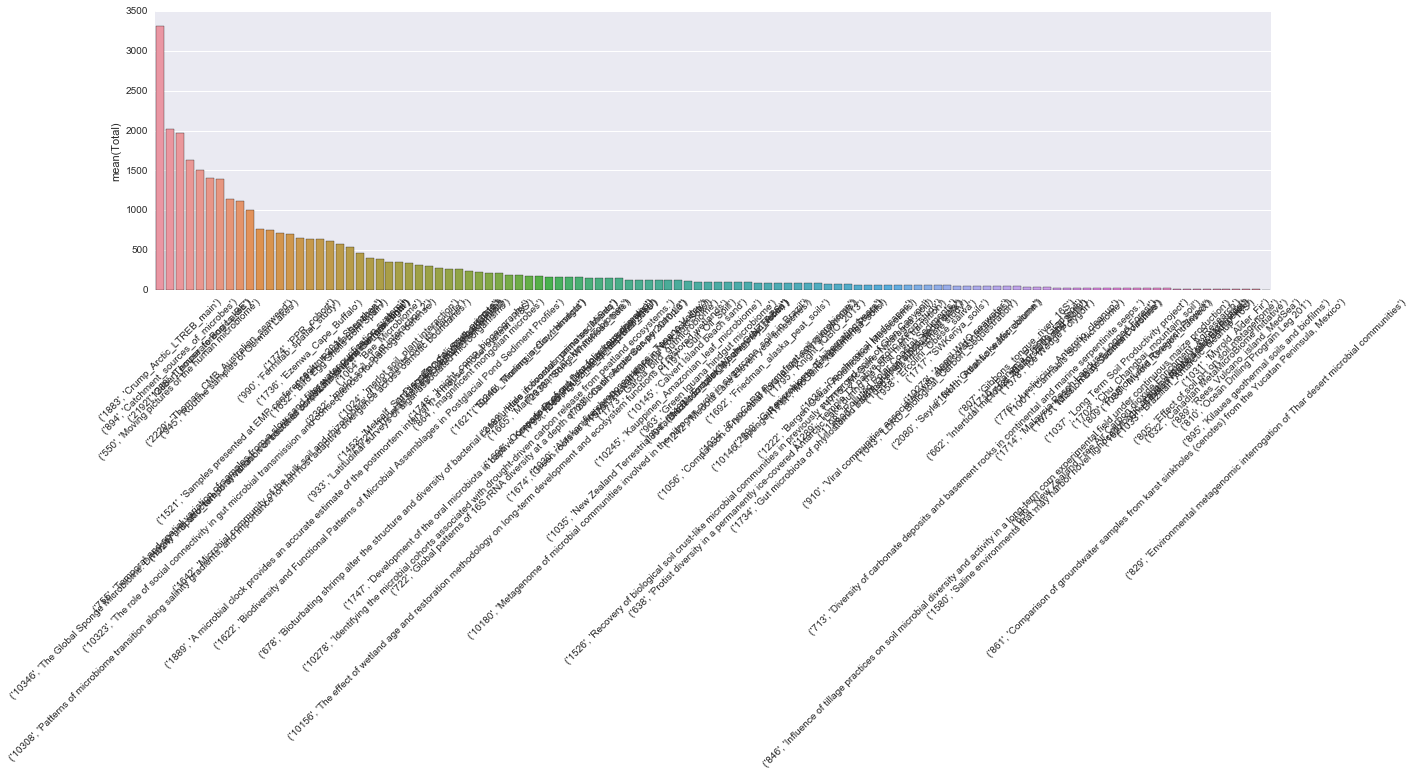

In [187]:
plt.figure(figsize=(20,5))
ph = sns.barplot(studies_groupby_unstack_sorted.index, studies_groupby_unstack_sorted)
for item in ph.get_xticklabels():
    item.set_rotation(45)

In [186]:
sns.barplot?

### Write refined mapping file and list of studies

In [168]:
today = datetime.datetime.today()
df_refined.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_refined_%s.tsv' % today.strftime('%Y%m%d'), sep='\t')

In [169]:
studies_groupby_unstack.to_csv('/Users/luke/emp/metadata-refine/emp_studies_no_controls_%s.tsv' % today.strftime('%Y%m%d'), sep='\t')